<a href="https://colab.research.google.com/github/TonyLiu836/CSCI5525-MachineLearning/blob/main/CSCI5525HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CSCI5525 HW 1
Tony Liu - ID: 5383942

In [3]:
from google.colab import drive
drive.mount('drive')


Mounted at drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets 
import math

#change path for datasets

boston_data_path = "/content/drive/MyDrive/Grad School/Spring2022/CSCI5525 ML/HW1/boston.csv"        
digits_data_path = "/content/drive/MyDrive/Grad School/Spring2022/CSCI5525 ML/HW1/digits.csv"
#boston_data_path = "C:\\GradSchool\\Spring2022\\CSCI5525ML\\HW1\\boston.csv"
#digits_data_path = "C:\\GradSchool\\Spring2022\\CSCI5525ML\\HW1\\digits.csv"


In [4]:

def getBostonDataset(tau):
    boston = np.loadtxt(open(boston_data_path, "rb"), delimiter=",", skiprows=1)
    boston = np.asarray(boston)
    #X = boston[:,:-1]
    y = boston[:,-1:]
    boundary_value = np.percentile(y, tau)      #split boston dataset into either 50 or 75 
    for i in range(len(y)):
        if y[i] >= boundary_value:
            boston[i][-1] = 1
        else:
            boston[i][-1] = 0
    #return X, y
    return boston

def getDigitsDataset():
    digits = np.loadtxt(open(digits_data_path, "rb"), delimiter=",", skiprows=1)
    #data = datasets.load_digits()
    return digits


def chooseDataset(dataset):
    if dataset == "Boston50":
        boston50 = getBostonDataset(50)
        return boston50

    elif dataset == "Boston75":
        boston75= getBostonDataset(75)
        return boston75

    else:
        digits = getDigitsDataset()
        return digits



# LDA1dThres (Working)

In [ ]:
from random import randrange
from collections import defaultdict
#split data into 10-folds
def crossValSplit(dataset, folds = 10):
    fold_size = int(len(dataset) / folds)
    split_dataset = []
    dataset_copy = dataset
    for i in range(folds):
        each_fold = []
        while len(each_fold) < fold_size:
            randSample = randrange(len(dataset_copy[0]))

            each_fold.append(dataset_copy[randSample])
            np.delete(dataset_copy,randSample)
        split_dataset.append(each_fold)
    
    return split_dataset 

#seperate samples into classes based on their labels
def seperateData(data, labels):
    class1 = []       #y=1 class
    class0 = []       #y=0 class
    for i in range(np.shape(data)[0]):

        if labels[i] == 1:
            class1.append(data[i])
        else:
            class0.append(data[i])
    return class0, class1

def softmax(vect):
    e = np.exp(vect)
    return e / e.sum()


#get mean of features in each class
def calcMeans(class0, class1):
    #print(np.shape(class0))
    class1Mean = np.mean(class1, axis = 0)      
    class0Mean = np.mean(class0, axis = 0)      
    return class0Mean, class1Mean

#finds the between-class scatter(SB) and within-class scatter(SW)
def calcCovariances(class0, class1, class0Mean, class1Mean):
    diffMeans = np.asarray(class1Mean - class0Mean)
    SB = np.matmul(np.transpose([diffMeans]), [diffMeans])
    length = len(class0[0])
    sum0 = 0
    sum1 = 0
    for n in range(len(class0Mean)):
        temp0 = class0[n] - class0Mean
        sum0 += np.matmul(np.transpose([temp0]), [temp0])

    for n in range(len(class1Mean)):  
        temp1 = class1[n] - class1Mean
        sum1 += np.matmul(np.transpose([temp1]), [temp1])

    SW = sum0 + sum1

    return SB, SW


# projects samples data @ W.T
def projectData(W, data):
    #projectedPts = []
    #print(np.shape(data))
    #print(np.shape(W))
    projectedPts = data @ W

    return projectedPts



# takes in samples of both classes and then finds the best boundary to classify samples
def trainLDA1D(train_data, train_labels):
    class0, class1 = seperateData(train_data,train_labels)
    class0Mean, class1Mean = calcMeans(class0, class1)
    SB,SW = calcCovariances(class0,class1, class0Mean, class1Mean)

    #eigVal, eigVect = np.linalg.eig(np.matmul(np.linalg.pinv(SW),SB))     #find the largest eigenvalue and the corresponding eigenvector
    #largestEigValInd = np.where(eigVal == max(eigVal))
    #W = eigVect[largestEigValInd][0]                                    #set W to be the previously found eigenvector

    eigVal, eigVect = np.linalg.eig(np.linalg.pinv(SW) @ SB)
    eigPairs = [(abs(eigVal[i]), eigVect[:,i]) for i in range(len(eigVal))]       #combine the eigval & eigvect into pairs
    sortedEigPairs = sorted(eigPairs, key = lambda x: x[0], reverse = True)       #sort the eigen pairs in descending order 
    W = np.transpose([sortedEigPairs[0][1]])
    #print(W)
  
    projPtsC0 = projectData(W, class0)
    projPtsC1 = projectData(W, class1)
    
    projC0Mean, projC1Mean = calcMeans(projPtsC0, projPtsC1)            #assume P(x|Ci) are Gaussian and calc mean, cov, priors
    projMeans = [projC0Mean, projC1Mean]

    projC0Cov = np.cov(projPtsC0, rowvar = False)
    projC1Cov = np.cov(projPtsC1, rowvar = False)
    projCovs = [projC0Cov, projC1Cov]

    priorC1 = len(class0)/(len(class0) + len(class1))
    priorC2 = len(class1)/ (len(class0) + len(class1))
    priors = [priorC1, priorC2]

    return W, projMeans, projCovs, priors

def predict(data, W, means, covs, priors):
    y_hat = []
    proj = projectData(W, data)  
    proj = np.asarray(proj)
    for sample in proj:
        sample_pred = []
        for i in range(len(means)):                     #use the un-simplified discriminant form 
            #invCov = np.linalg.inv(covs[i])
            t1 = -(0.5) * np.log(2*math.pi)
            t2 = np.log(covs[i])
            t3 = ((sample - means[i])**2) / (2*covs[i]**2)
            t4 = np.log(priors[i])
            g = t1 - t2 - t3 + t4
            sample_pred.append(g)
        pred = softmax(sample_pred)
        y_hat.append(np.argmax(pred))
    
    return y_hat


def errorAndStdDev(prediction, gndTruth):
    counter = 0
    temp = 0
    gndTruthMean = sum(gndTruth) / len(gndTruth)
    for i in range(len(prediction)):
        #print(prediction[i], gndTruth[i])
        if prediction[i] != gndTruth[i]:
            counter += 1
    
    error = counter / len(prediction) * 100
    
    mean = np.mean(gndTruth)
    for i in range(len(prediction)):
        temp += (prediction[i] - mean)**2
    stdDev = np.sqrt(temp/len(gndTruth)) / np.sqrt(len(prediction)) *100 
    return error, stdDev

def LDA1dThres(filename, num_crossval):#, prior):
    split_data = crossValSplit(filename)
    
    globalError = 0
    globalStdDev = 0

    fold_error = []
    fold_stddev = []
    for i in range(len(split_data)):
        #print(len(split_data[i]))
        test_data = np.copy(split_data[i])
        test_labels = test_data[:,-1]
        test_data = test_data[:,:-1]

        train_data_folds = np.delete(np.copy(split_data),i,0)
        folds, samples, features = np.shape(train_data_folds)
        train_data = np.reshape(train_data_folds, (folds * samples, features))
        
        train_labels = train_data[:,-1]

        train_data = train_data[:,:-1]

        class0, class1 = seperateData(train_data, train_labels)
        W, means,covs, priors = trainLDA1D(train_data, train_labels)
        trainPred = predict(train_data, W, means, covs, priors)
        trainError, trainStdDev = errorAndStdDev(trainPred, train_labels)

        prediction = predict(test_data, W, means, covs, priors)
        error, stdDev= errorAndStdDev(prediction, test_labels)
        #fold_error.append(error)
        #fold_stddev.append(stdDev)
        globalStdDev += stdDev
        globalError += error
        print("Fold= ", i, "  Train error= ", trainError, "%  Train std dev= ", trainStdDev, "  Test Error", error, "%  Test std dev= ", stdDev)
    
    
    print("Avg Error = ", globalError / num_crossval, "%")
    print("Avg Standard Deviation = ", globalStdDev / num_crossval)

#dataset, prior = chooseDataset("Boston50")
#print("dataset=", dataset)
dataset= chooseDataset("Boston50")
LDA1dThres(dataset, 10)#, prior)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


Fold=  0   Train error=  26.666666666666668 %  Train std dev=  2.434322477800744   Test Error 22.0 %  Test std dev=  7.0710678118654755
Fold=  1   Train error=  33.77777777777778 %  Train std dev=  2.418039201552962   Test Error 48.0 %  Test std dev=  8.376156636548767
Fold=  2   Train error=  28.000000000000004 %  Train std dev=  2.4179484326120124   Test Error 30.0 %  Test std dev=  7.63675323681471
Fold=  3   Train error=  27.555555555555557 %  Train std dev=  2.432089991837274   Test Error 28.000000000000004 %  Test std dev=  7.222188034107117
Fold=  4   Train error=  28.666666666666668 %  Train std dev=  2.4352464433922987   Test Error 24.0 %  Test std dev=  7.200000000000002
Fold=  5   Train error=  28.22222222222222 %  Train std dev=  2.4390512896238294   Test Error 22.0 %  Test std dev=  7.0710678118654755
Fold=  6   Train error=  27.555555555555557 %  Train std dev=  2.4270989530396907   Test Error 28.000000000000004 %  Test std dev=  7.359347797189642
Fold=  7   Train error= 

# LDA2dGaussGM

In [ ]:
from random import randrange


#split data into 10-folds
def crossValSplit(dataset, folds = 10):
    fold_size = int(len(dataset) / folds)
    split_dataset = []
    dataset_copy = dataset
    for i in range(folds):
        each_fold = []
        while len(each_fold) < fold_size:
            randSample = randrange(len(dataset_copy[0]))
            each_fold.append(dataset_copy[randSample])
            np.delete(dataset_copy,randSample)
        split_dataset.append(each_fold)
    
    return split_dataset 

#seperate samples into classes based on their labels
def seperateData(data, labels):
    data_dict = {0:[],              #use dictionary to store samples of different classes
                1:[],
                2:[],
                3:[],
                4:[],
                5:[],
                6:[],
                7:[],
                8:[],
                9:[]}

    for i in range(len(data)):
        data_dict[labels[i]].append(data[i,:])
    return data_dict

def calcMeans(data_dict):
    class_means = []                       #list of means of features for samples of each class
    for value in data_dict.values():
        mean = np.mean(value, axis = 0)
        class_means.append(mean) 
    temp = sum(class_means)                              #find overall mean 
    overall_mean = (1/len(class_means)) * temp

    return class_means, overall_mean


#finds the between-class scatter and within-class scatter
def calcCovariances(data_dict, class_means, overall_mean):
    num_classes = len(class_means)

    Si = []
    counter1 = 0
    for key, value in data_dict.items():
        for i in range(len(value)):
            diff = value[i] - class_means[key]
            counter1 += np.matmul(np.transpose([diff]), [diff])
        Si.append(counter1)

    SW = sum(Si)                        #within class scatter

    SB = 0                              #between class scatter
    for i in range(num_classes):
        diffMeans = class_means[i] - overall_mean
        SB += len(data_dict[i]) * np.matmul(np.transpose([diffMeans]), [diffMeans])
    
    return SB, SW

# projects samples by multiplying W.T and each sample 
def projectData(W, data):
    projectedData = []
    for i in range(len(data)):
        projectedData.append(data[i] @ np.transpose(W))
    return projectedData


def findGaussParams(train_data, labels ,W):
    means = {}
    covs = {}
    priors = {}

    data_dict = seperateData(train_data, labels)
    samples = len(train_data)
    for key, value in data_dict.items():
        
        projection = projectData(W, value)
        means[key] = np.mean(projection, axis = 0)
        covs[key] = np.cov(projection, rowvar = False)
        priors[key] = len(data_dict[key])/samples
    return means,covs,priors


def Gaussian(u, sigma, sample):
    d = len(sample)
    #smallVals = 1e-15*np.eye(np.shape(sigma)[0])
    #sigma = sigma + smallVals
    temp1 = (2*math.pi)**(d/2) * (np.linalg.det(sigma)**(1/2))
    temp2 = (-1/2) * (sample-u) @ np.linalg.inv(sigma) @ np.transpose([sample-u])
    gauss = (1/temp1) * np.exp(temp2)
    return gauss


# takes in samples of both classes and then finds the best boundary to classify samples
def train(train_data, labels, test_data):

    data_dict = seperateData(train_data, labels)
    class_means, overall_mean = calcMeans(data_dict)
    SB,SW = calcCovariances(data_dict, class_means, overall_mean)
    eigVal, eigVect = np.linalg.eig(np.matmul(np.linalg.pinv(SW), SB))

    idx = eigVal.argsort()[::-1]
    k=2
    idx = eigVal.argsort()[-k:][::-1]
    W = eigVect[idx]
   
    u, sigma, priors = findGaussParams(train_data, labels, W)
    return W,u,sigma,priors 

def predict(data,W,u,sigma,priors):
    y_hat = []
    proj = projectData(W, data)
    for sample in proj:
        probs = []
        for c in range(len(sigma)):        #for each class, find gaussian and multiply w prior
            gauss = Gaussian(u[c], sigma[c], sample)

            prob = priors[c] * gauss
            probs.append(prob)
        
        y_hat.append(probs)
    predictions = np.argmax(y_hat, axis=1)
    
    return predictions

def errorAndStdDev(y_hat, gndTruth):
    counter = 0
    temp = 0
    gndTruthMean = sum(gndTruth) / len(gndTruth)
    for i in range(len(y_hat)):
        if y_hat[i] != gndTruth[i]:
            counter += 1
    
    error = counter / len(y_hat)
    
    for i in range(len(gndTruth)):
        temp +=  (y_hat[i] - gndTruthMean)**2
    stdDev = np.sqrt(temp/len(gndTruth))
    return error, stdDev


def LDA2dGaussGM(filename, num_crossval):
    split_data = crossValSplit(filename)
    
    globalError = 0
    globalStdDev = 0

    fold_error = []
    fold_stddev = []
    for i in range(len(split_data)):
        test_data = np.copy(split_data[i])
        test_data_labels = test_data[:,-1]
        test_data = test_data[:,:-1]
        
        train_data_folds = np.delete(np.copy(split_data),i,0)
        folds, samples, features = np.shape(train_data_folds)
        train_data = np.reshape(train_data_folds, (folds * samples, features))
        train_data_labels = train_data[:,-1]
        train_data = train_data[:,:-1]
        
        W,u,sigma,priors = train(train_data, train_data_labels, test_data)
        
        trainPred = predict(train_data,W,u,sigma,priors)
        trainError, trainStdDev = errorAndStdDev(trainPred, train_data_labels)
        
        testPred = predict(test_data, W, u, sigma, priors)
        testError, testStdDev = errorAndStdDev(testPred,test_data_labels)

        print("Fold= ", i, "  Train error= ", trainError * 100, "%  Train std dev= ", trainStdDev, "  Test Error", testError * 100, "%   Test std dev= ", testStdDev)
        globalError += trainError 
        globalStdDev += trainStdDev
    
    print("Avg Error = ", globalError / num_crossval * 100, "%")
    print("Avg Standard Deviation = ", globalStdDev / num_crossval)

dataset = chooseDataset("digits")
LDA2dGaussGM(dataset, 10)

Fold=  0   Train error=  49.534450651769085 %  Train std dev=  [3.0674529]   Test Error 53.63128491620112 %   Test std dev=  [3.05378684]
Fold=  1   Train error=  59.40409683426443 %  Train std dev=  [2.86782429]   Test Error 67.0391061452514 %   Test std dev=  [2.8089061]
Fold=  2   Train error=  63.00434512725015 %  Train std dev=  [2.70585035]   Test Error 63.128491620111724 %   Test std dev=  [2.71245016]
Fold=  3   Train error=  52.6381129733085 %  Train std dev=  [2.98181592]   Test Error 45.81005586592179 %   Test std dev=  [2.94029941]
Fold=  4   Train error=  51.21042830540037 %  Train std dev=  [2.85189139]   Test Error 50.27932960893855 %   Test std dev=  [2.81863369]
Fold=  5   Train error=  35.071384233395406 %  Train std dev=  [2.93270766]   Test Error 39.10614525139665 %   Test std dev=  [2.93533822]
Fold=  6   Train error=  65.67349472377406 %  Train std dev=  [2.85706829]   Test Error 68.71508379888269 %   Test std dev=  [2.86044976]
Fold=  7   Train error=  71.1359404

# LDA2dGaussianGM (Working)

In [ ]:
from random import randrange
from collections import defaultdict
import matplotlib.pyplot as plt

#split data into 10-folds
def crossValSplit(dataset, folds = 10):
    fold_size = int(len(dataset) / folds)
    split_dataset = []
    dataset_copy = dataset
    for i in range(folds):
        each_fold = []
        while len(each_fold) < fold_size:
            randSample = randrange(len(dataset_copy[0]))
            each_fold.append(dataset_copy[randSample])
            np.delete(dataset_copy,randSample)
        split_dataset.append(each_fold)
    
    return split_dataset
    
def errorAndStdDev(y_hat, gndTruth):
    counter = 0
    temp = 0
    gndTruthMean = sum(gndTruth) / len(gndTruth)

    for i in range(len(y_hat)):
        print(y_hat[i], "  ", gndTruth[i])
        if y_hat[i] != gndTruth[i]:
            counter += 1
    
    error = counter / len(y_hat)

    for i in range(len(gndTruth)):
        temp +=  (y_hat[i] - gndTruthMean)**2
    stdDev = np.sqrt(temp/len(gndTruth))
    return error, stdDev


#seperate samples into classes based on their labels
def seperateData(data, labels):
    data_dict = {0:[],              #use dictionary to store samples of different classes
                1:[],
                2:[],
                3:[],
                4:[],
                5:[],
                6:[],
                7:[],
                8:[],
                9:[]}

    for i in range(len(data)):
        data_dict[labels[i]].append(data[i,:])
    return data_dict

#list of means of features for samples of each class and overall mean
def calcMeans(data_dict):
    class_means = []                       
    for value in data_dict.values():
        mean = np.mean(value, axis = 0)
        class_means.append(mean) 
    temp = sum(class_means)                              
    overall_mean = (1/len(class_means)) * temp

    return class_means, overall_mean


#finds the between-class scatter and within-class scatter
def calcCovariances(data_dict, class_means, overall_mean):
    num_classes = len(class_means)
    Si = []
    counter1 = 0

    for key, value in data_dict.items():
        for i in range(len(value)):
            diff = value[i] - class_means[key]
            counter1 += np.matmul(np.transpose([diff]), [diff])
        Si.append(counter1)

    SW = sum(Si)                        #within class scatter

    SB = 0                              #between class scatter
    for i in range(num_classes):
        diffMeans = class_means[i] - overall_mean
        SB += len(data_dict[i]) * np.matmul(np.transpose([diffMeans]), [diffMeans])
    
    return SB, SW

def oneHot(labels):
    num_classes = len(set(labels))
    onehot_labels = np.zeros((len(labels), num_classes))
    for i in range(len(labels)):          #encodes labels to 1-hot 
        #print(i, labels[i])
        onehot_labels[i][int(labels[i])-1] = 1

    return onehot_labels

# projects data along W 
def projectData(W, data):
    #print(np.shape(W))
    #print(np.shape(data))
    projectedData = []
    for i in range(len(data)):
        #projectedData.append(data[i] @ np.transpose(W))
        projectedData.append(data[i] @ W)
    return projectedData

#finds mean, cov, and prior for each class
def findGaussParams(data_dict, labels, W):
    means = []
    covs = []
    priors = []
    total_cov = 0

    samples = len(labels)
    for key, value in data_dict.items():
        projection = projectData(W, value)
        means.append(np.mean(projection, axis = 0))
        cov = np.cov(projection, rowvar = False)      #2x2
        covs.append(cov)
        prior = len(data_dict[key])/samples
        total_cov += prior * cov
        priors.append(prior)
        
    return means,covs,priors, total_cov

def softmax(vect):
    e = np.exp(vect)
    return e / e.sum()


def plot(projdata, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.scatter(projdata[:,0],projdata[:,1] , c=labels, lw=0)

#finds the optimal W matrix to project data to 2D
#finds mean, cov, and prior of each class
def trainLDA2D(train_data, labels, test_data):
    num_classes = len(set(labels))
    data_dict = seperateData(train_data, labels)
    labels_onehot = oneHot(labels)

    class_means, overall_mean = calcMeans(data_dict)
    SB,SW = calcCovariances(data_dict, class_means, overall_mean)   
    
    eigVal, eigVect = np.linalg.eig(np.linalg.pinv(SW) @ SB)
    eigPairs = [(abs(eigVal[i]), eigVect[:,i]) for i in range(len(eigVal))]       #combine the eigval & eigvect into pairs
    sortedEigPairs = sorted(eigPairs, key = lambda x: x[0], reverse = True)       #sort the eigen pairs in descending order 
    largest = sortedEigPairs[0][1]
    seclargest = sortedEigPairs[1][1]
    W = np.transpose(np.vstack((largest,seclargest)))                              #W formed by  eigenvects corresponding to the 2 largest eigenvals
    #print(np.shape(W))

    proj = projectData(W, train_data)
    proj = np.asarray(proj)
    #projplot = plot(proj, labels)

    proj_class_mean, proj_class_cov, priors, total_cov = findGaussParams(data_dict, labels, W)      #find mean,cov, prior for each class

    return W, proj_class_mean, proj_class_cov, priors


def predict(data, W, means, covs, priors):
    y_hat = []
    proj = projectData(W, data)  
    proj = np.asarray(proj)
    for sample in proj:
        sample_pred = []
        for i in range(len(means)):                     #use the un-simplified discriminant form 
            invCov = np.linalg.inv(covs[i])
            t1 = (-1/2) * invCov
            t2 = invCov @ means[i]
            t3 = (-1/2) * means[i] @ invCov @ np.transpose([means[i]]) - (1/2)*np.log(np.linalg.det(covs[i])) + np.log(priors[i])
            g = (sample @ t1 @ np.transpose([sample])) + sample @ t2 + t3
            sample_pred.append(g)
        pred = softmax(sample_pred)
        y_hat.append(np.argmax(pred))
    
    return y_hat

def LDA2dGaussGM(filename, num_crossval):
    split_data = crossValSplit(filename)
    
    globalError = 0
    globalStdDev = 0

    fold_error = []
    fold_stddev = []
    for i in range(len(split_data)):
        test_data = np.copy(split_data[i])
        test_labels = test_data[:,-1]
        test_data = test_data[:,:-1]
        
        train_data_folds = np.delete(np.copy(split_data),i,0)
        folds, samples, features = np.shape(train_data_folds)
        train_data = np.reshape(train_data_folds, (folds * samples, features))
        train_labels = train_data[:,-1]
        train_data = train_data[:,:-1]

        W, means, covs, priors = trainLDA2D(train_data, train_labels, test_data)
        
        trainPred = predict(train_data, W, means, covs, priors)
        trainError, trainStdDev = errorAndStdDev(trainPred, train_labels)
        
        testPred = predict(test_data, W, means, covs, priors)
        testError, testStdDev = errorAndStdDev(testPred, test_labels)

        print("Fold= ", i, "  Train error= ", trainError * 100, "%  Train std dev= ", trainStdDev, "  Test Error", testError * 100, "%   Test std dev= ", testStdDev)
        globalError += trainError 
        globalStdDev += trainStdDev
    
    print("Avg Error = ", globalError / num_crossval * 100, "%")
    print("Avg Standard Deviation = ", globalStdDev / num_crossval)

dataset = chooseDataset("digits")
LDA2dGaussGM(dataset, 10)

# logisticRegression 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in exp


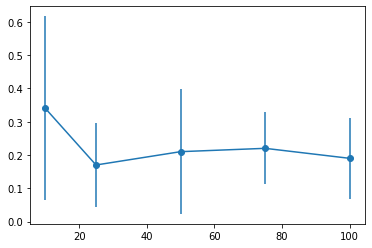

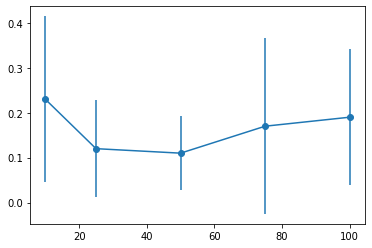

In [ ]:
import random
from random import randrange
from collections import defaultdict

#split data into 10-folds
def crossValSplit(dataset, folds = 10):
    fold_size = int(len(dataset) / folds)
    split_dataset = []
    dataset_copy = dataset
    for i in range(folds):
        each_fold = []
        while len(each_fold) < fold_size:
            randSample = randrange(len(dataset_copy[0]))
            each_fold.append(dataset_copy[randSample])
            np.delete(dataset_copy,randSample)
        split_dataset.append(each_fold)
    
    return split_dataset 

def errorAndStdDev(y_hat, gndTruth):
    counter = 0
    temp = 0
    gndTruthMean = sum(gndTruth) / len(gndTruth)
    #print("yhat len",len(y_hat))
    #print("gnd len",len(gndTruth))
    for i in range(len(y_hat)):
        #print("y_hat[i]", y_hat[i], "  gndTruth[i]", gndTruth[i])
        if y_hat[i] != gndTruth[i]:
            counter += 1
    
    error = counter / len(y_hat)
    
    for i in range(len(gndTruth)):
        temp +=  (y_hat[i] - gndTruthMean)**2
    stdDev = np.sqrt(temp/len(gndTruth))
    return error, stdDev

def oneHot(labels, num_classes):
    
    onehot_labels = np.zeros((len(labels), num_classes))
    for i in range(len(labels)):          #encodes labels to 1-hot 
        #print(i, labels[i], onehot_labels[i,:])
        onehot_labels[i][int(labels[i])-1] = 1
    return onehot_labels

#seperate samples into classes based on their labels
def seperateData(data, labels):
    data_combined = [(labels[i], data[i]) for i in range(len(labels))]
    data_dict = defaultdict(list)

    for key, val in data_combined:        #seperates data based on class
        data_dict[key].append(val)

    return data_dict

def softmax(vect):
    e = np.exp(vect)
    return e / e.sum()

def sigmoid(z):
    ans = 1/(1 + np.exp(-z)) 
    return ans

def findCost(train_labels,y_hat):
    #total_loss = 0
    #print(train_labels)
    c = 1e-10
    cost_y0 = (1 - train_labels) * np.log(1 - y_hat +c)
    cost_y1 = train_labels * np.log(y_hat +c)
    loss = -(1/len(y_hat)) * np.sum(cost_y0 + cost_y1)

    return loss

def classify(data, W):
    #final_pred = np.zeros(len(data))
    #print("data", np.shape(data))
    #print("w", np.shape(W))
    pred = sigmoid(data @ W)

    #final_pred = np.argmax(softmax(pred), axis = 1)
    #final_pred = np.argmax(softmax(pred))
    #final_pred = softmax(pred)
    return pred

def calcDeltaE(train_data, train_labels, W, num_classes, num_samples): 

    
    for i in range():


def trainBinaryLogReg(train_data, train_labels):
    #print("train labels shape", np.shape([train_labels]))
    #print("data shape", np.shape(train_data))
    num_features = np.shape(train_data)[1]
    num_samples = len(train_data)
    #num_classes = len(train_labels[0])
    W = np.random.normal(0, 1, size=(num_features,1))
    #print("W shape", np.shape(W))
    #adsf
    lr = 0.01
    iters = 1000

    error_history = []
    for i in range(iters):
        
        #print("w shape=", np.shape(W))
        #print("data shape=", np.shape(train_data))
        z =  train_data @ W

        y_hat = sigmoid(z)

        deltaE = (np.transpose(train_data) @ (y_hat - np.transpose([train_labels])))
        W -= lr * deltaE

        error = findCost(train_labels, y_hat)
        #print(error)
        error_history.append(error)
    
    return W, error_history



def trainMulticlassLogReg(train_data, train_labels):
    num_features = np.shape(train_data)[1]
    num_samples = len(train_data)
    num_classes = len(train_labels[0])
    W = np.random.normal(0, 1, size=(num_features, num_classes))
    #print("W shape", np.shape(W))
    #adsf
    lr = 1
    iters = 1000

    error_history = []
    for i in range(iters):
        z =  train_data @ W

        y_hat = np.argmax(softmax(z), axis = 1)
        
        deltaE = calcDeltaE(train_data, train_labels, W, num_classes, num_samples)

        #deltaE = (np.transpose(train_data) @ (y_hat - np.transpose([train_labels])))
        W -= lr * deltaE

        error = findCost(train_labels, y_hat)
        #print(error)
        error_history.append(error)
    
    return W, error_history

def splitDataTrainTest(data):
    data = np.asarray(data)
    perm_data = np.random.permutation(data)
    train_size = int(0.8 * len(data))
    train_split = np.asarray(perm_data[:train_size])
    test_split = np.asarray(perm_data[train_size:])

    return train_split, test_split

def trainPercent(train_split, percent):
    #print(percent * len(train_split))
    #print(percent)
    #print(np.shape(train_split))
    #random.shuffle(train_split)
    train_split = np.asarray(train_split)
    perm_train_split = np.random.permutation(train_split)
    #train_split = np.asarray(train_split)
    if percent != 100:
        train_size = int(percent/100 * len(perm_train_split))
    else:
        return train_split
    
    train_data = perm_train_split[:train_size,:]
    #print("train size=", train_size, "  len train data", len(train_data) )
    return train_data


def logisticRegression(filename, dataset, num_splits, percent):
    split_data = crossValSplit(dataset)
    
    globalError = 0
    globalStdDev = 0

    fold_error = []
    fold_stddev = []
    gen_error_history = []
    for i in range(len(split_data)):
        gen_error_split = []
        num_samples = len(split_data[i])

        train_split, test_split = splitDataTrainTest(split_data[i])
        #print("train split len", len(train_split))
        test_labels = test_split[:,-1]
        num_classes = len(set(test_labels))
        
        onehot_test_labels = oneHot(test_labels, num_classes)
        test_data = test_split[:,:-1]

        for j in percent:

            train_percent = trainPercent(train_split, j)
            train_labels = train_percent[:,-1]
            
            train_data = train_percent[:,:-1]

            if num_classes <=2:
                W, cost_history = trainBinaryLogReg(train_data, train_labels)

            else:
                onehot_train_labels = oneHot(train_labels, num_classes)
                W, cost_history = trainMulticlassLogReg(train_data, onehot_train_labels)


            trainPred = classify(train_data, W)
            #print(trainPred)
            trainError, trainStdDev = errorAndStdDev(trainPred, train_labels)
            #print(trainError)
            testPred = classify(test_data,W)
            testError, testStdDev = errorAndStdDev(testPred, test_labels)
            #print("percent=",j,"train error=", trainError * 100,"  test error=", testError * 100)
            #trainPred = predict(train_data,W,u,sigma,priors)
            #trainError, trainStdDev = errorAndStdDev(trainPred, train_data_labels)
            gen_error_split.append(testError)
        #print("   ")
        gen_error_history.append(gen_error_split)

    avg_error = np.mean(gen_error_history, axis = 0)
    error_stddev = np.std(gen_error_history, axis = 0)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.errorbar(percent, avg_error ,error_stddev,fmt='-o')
    #ax.plot(percent,avg_error , c=labels, lw=0)

percent = [10,25,50,75,100]
#datasetNames = ["Boston50", "Boston75", "digits"]
datasetNames = ["Boston50", "Boston75"]   #["Boston50"]
for i in datasetNames:
    dataset = chooseDataset(i)
    logisticRegression(i, dataset, 10, percent)

# Logist Regression (Working)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in exp


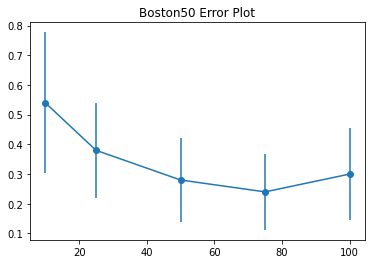

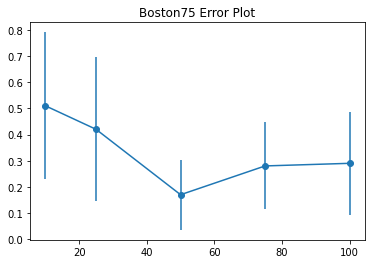

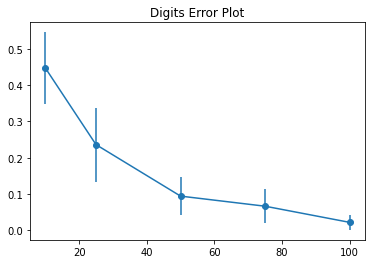

In [44]:
import random
from random import randrange
from collections import defaultdict

#split data into 10-folds
def crossValSplit(dataset, folds = 10):
    fold_size = int(len(dataset) / folds)
    split_dataset = []
    dataset_copy = dataset
    for i in range(folds):
        each_fold = []
        while len(each_fold) < fold_size:
            randSample = randrange(len(dataset_copy[0]))
            each_fold.append(dataset_copy[randSample])
            np.delete(dataset_copy,randSample)
        split_dataset.append(each_fold)
    
    return split_dataset 

def errorAndStdDev(y_hat, gndTruth):
    counter = 0
    temp = 0
    gndTruthMean = sum(gndTruth) / len(gndTruth)
    #print("yhat len",len(y_hat))
    #print("gnd len",len(gndTruth))
    for i in range(len(y_hat)):
        #print("y_hat[i]", y_hat[i], "  gndTruth[i]", gndTruth[i])
        if y_hat[i] != gndTruth[i]:
            counter += 1
    
    error = counter / len(y_hat)
    
    for i in range(len(gndTruth)):
        temp +=  (y_hat[i] - gndTruthMean)**2
    stdDev = np.sqrt(temp/len(gndTruth))
    return error, stdDev

#seperate samples into classes based on their labels
def seperateData(data, labels):
    data_combined = [(labels[i], data[i]) for i in range(len(labels))]
    data_dict = defaultdict(list)

    for key, val in data_combined:        #seperates data based on class
        data_dict[key].append(val)

    return data_dict

def sigmoid(z):
    ans = 1/(1 + np.exp(-z)) 
    return ans

def findCost(train_labels, z):
    c = 1e-10
    samples = len(train_labels)

    cost_y0 = -1 * np.transpose([train_labels]) * np.log(z +c)
    cost_y1 = (1 - np.transpose([train_labels])) * np.log(1 - z +c)
    
    loss = (1/samples) * np.sum(cost_y0 + cost_y1)

    return loss

def classifyBinary(data, W):
    pred = sigmoid(data @ W)
    return pred


def classifyMulti(data, W):
    data = np.insert(data, 0, 1, axis=1)
    W = np.reshape(W, (-1, np.shape(data)[1]))
    pred = np.argmax(sigmoid(data @ np.transpose(W)), axis = 1)

    return pred


def trainBinaryLogReg(train_data, train_labels):
    
    num_features = np.shape(train_data)[1]
    num_samples = len(train_data)
    W = np.random.normal(0, 1, size=(num_features,1))
    lr = 0.1                                          #learning rate and iteration values were found through trial and error
    iters = 1750
    error_history = []
    for i in range(iters):
        
        z = sigmoid(train_data @ W)
        
        deltaE = (1/num_samples) * (np.transpose(train_data) @ (np.transpose([train_labels]) - z))
        W += lr * deltaE

        error = findCost(train_labels, z)
        
        error_history.append(error)
    
    return W, error_history

#use 1-vs-all for multi-class logistic regression
def trainMulticlassLogReg(train_data, train_labels, num_classes):
    
    num_samples = len(train_data)
    lr = 0.1
    iters = 500
    error_history = []
    train_data=np.insert(train_data, 0 ,1, axis = 1)
    weights = []
    
    for c in range(num_classes):
        oneVall_y = np.where(train_labels == c, 1, 0)
        w = np.random.normal(0, 1, size=(np.shape(train_data)[1],1))

        for i in range(iters):

            z  = sigmoid(train_data @ w) 
  
            grad = (1/num_samples) * (np.transpose(train_data) @ (np.transpose([oneVall_y]) - z))

            w += lr * grad

            error = findCost(oneVall_y, z)
            error_history.append(error)
        
        weights.append(w)
  
    weights = np.asarray(weights)
    return weights, error_history


def splitDataTrainTest(data):
    data = np.asarray(data)
    perm_data = np.random.permutation(data)
    train_size = int(0.8 * len(data))
    train_split = np.asarray(perm_data[:train_size])
    test_split = np.asarray(perm_data[train_size:])

    return train_split, test_split

def trainPercent(train_split, percent):
    train_split = np.asarray(train_split)
    perm_train_split = np.random.permutation(train_split)
    #train_split = np.asarray(train_split)
    if percent != 100:
        train_size = int(percent/100 * len(perm_train_split))
    else:
        return train_split
    
    train_data = perm_train_split[:train_size,:]
    return train_data


def logisticRegression(filename, dataset, num_splits, percent):
    split_data = crossValSplit(dataset)
    
    globalError = 0
    globalStdDev = 0

    fold_error = []
    fold_stddev = []
    gen_error_history = []
    for i in range(len(split_data)):
        gen_error_split = []
        num_samples = len(split_data[i])

        train_split, test_split = splitDataTrainTest(split_data[i])
        #print("train split len", len(train_split))
        test_labels = test_split[:,-1]
        
        num_classes = len(set(test_labels))               #sometimes there's a skewed split where not all of the classes will be included
        if num_classes > 2:                               #I'm hard coding the classes to avoid running into errors caused by skewed class splits
            num_classes = 10
        else:
            num_classes = 2

        test_data = test_split[:,:-1]

        for j in percent:

            train_percent = trainPercent(train_split, j)
            train_labels = train_percent[:,-1]
            
            train_data = train_percent[:,:-1]

            if num_classes <=2:
                W, cost_history = trainBinaryLogReg(train_data, train_labels)
                trainPred = classifyBinary(train_data, W)
                testPred = classifyBinary(test_data,W)

            else:
                W, cost_history = trainMulticlassLogReg(train_data, train_labels, num_classes)
                trainPred = classifyMulti(train_data, W)
                testPred = classifyMulti(test_data,W)
            
            #print(trainPred)
            #print(trainPred)
            trainError, trainStdDev = errorAndStdDev(trainPred, train_labels)
            #print(trainError)
            
            testError, testStdDev = errorAndStdDev(testPred, test_labels)
            #print("percent=",j,"train error=", trainError * 100,"  test error=", testError * 100)

            gen_error_split.append(testError)
        #print("   ")
        gen_error_history.append(gen_error_split)

    avg_error = np.mean(gen_error_history, axis = 0)
    error_stddev = np.std(gen_error_history, axis = 0)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.errorbar(percent, avg_error ,error_stddev,fmt='-o')
    plt.title(filename + " Error Plot")


percent = [10,25,50,75,100]
datasetNames = ["Boston50", "Boston75", "Digits"]
#datasetNames = ["Digits"]
#datasetNames = ["Boston50", "Boston75"]   #["Boston50"]
for i in datasetNames:
    dataset = chooseDataset(i)
    logisticRegression(i, dataset, 10, percent)

# naiveBayesGaussian (Working)

percent= 10 train error= 0.0   test error= 40.0
percent= 25 train error= 10.0   test error= 10.0
percent= 50 train error= 10.0   test error= 10.0
percent= 75 train error= 16.666666666666664   test error= 10.0
percent= 100 train error= 17.5   test error= 10.0
percent= 10 train error= 0.0   test error= 50.0
percent= 25 train error= 0.0   test error= 0.0
percent= 50 train error= 20.0   test error= 10.0
percent= 75 train error= 6.666666666666667   test error= 0.0
percent= 100 train error= 5.0   test error= 0.0
percent= 10 train error= 0.0   test error= 80.0
percent= 25 train error= 10.0   test error= 0.0
percent= 50 train error= 10.0   test error= 0.0
percent= 75 train error= 10.0   test error= 0.0
percent= 100 train error= 10.0   test error= 0.0
percent= 10 train error= 0.0   test error= 50.0
percent= 25 train error= 10.0   test error= 10.0
percent= 50 train error= 20.0   test error= 20.0
percent= 75 train error= 20.0   test error= 20.0
percent= 100 train error= 17.5   test error= 20.0
pe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log



percent= 25 train error= 0.0   test error= 0.0
percent= 50 train error= 15.0   test error= 20.0
percent= 75 train error= 13.333333333333334   test error= 0.0
percent= 100 train error= 10.0   test error= 0.0
percent= 10 train error= 0.0   test error= 30.0
percent= 25 train error= 0.0   test error= 0.0
percent= 50 train error= 15.0   test error= 20.0
percent= 75 train error= 20.0   test error= 20.0
percent= 100 train error= 20.0   test error= 20.0
percent= 10 train error= 0.0   test error= 30.0
percent= 25 train error= 0.0   test error= 20.0
percent= 50 train error= 0.0   test error= 20.0
percent= 75 train error= 3.3333333333333335   test error= 20.0
percent= 100 train error= 5.0   test error= 20.0
percent= 10 train error= 0.0   test error= 60.0
percent= 25 train error= 10.0   test error= 0.0
percent= 50 train error= 40.0   test error= 30.0
percent= 75 train error= 20.0   test error= 0.0
percent= 100 train error= 15.0   test error= 0.0
percent= 10 train error= 0.0   test error= 40.0
per

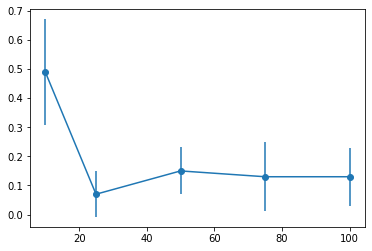

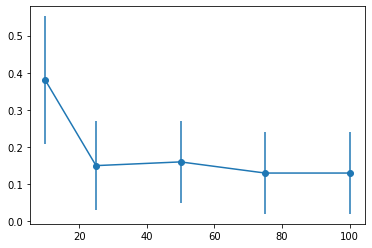

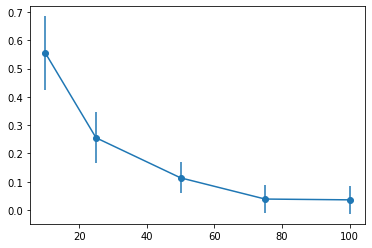

In [ ]:
import random
from random import randrange
from collections import defaultdict

#split data into 10-folds
def crossValSplit(dataset, folds = 10):
    fold_size = int(len(dataset) / folds)
    split_dataset = []
    dataset_copy = dataset
    for i in range(folds):
        each_fold = []
        while len(each_fold) < fold_size:
            randSample = randrange(len(dataset_copy[0]))
            each_fold.append(dataset_copy[randSample])
            np.delete(dataset_copy,randSample)
        split_dataset.append(each_fold)
    
    return split_dataset 

def errorAndStdDev(y_hat, gndTruth):
    counter = 0
    temp = 0
    gndTruthMean = sum(gndTruth) / len(gndTruth)
    #print("yhat len",len(y_hat))
    #print("gnd len",len(gndTruth))
    for i in range(len(y_hat)):
        #print("y_hat[i]", y_hat[i], "  gndTruth[i]", gndTruth[i])
        if y_hat[i] != gndTruth[i]:
            counter += 1
    
    error = counter / len(y_hat)
    
    for i in range(len(gndTruth)):
        temp +=  (y_hat[i] - gndTruthMean)**2
    stdDev = np.sqrt(temp/len(gndTruth))
    return error, stdDev

#seperate samples into classes based on their labels
def seperateData(data, labels):
    data_combined = [(labels[i], data[i]) for i in range(len(labels))]
    data_dict = defaultdict(list)

    for key, val in data_combined:        #seperates data based on class
        data_dict[key].append(val)

    return data_dict

#find mean, std dev, prior for training data which will be used to later to find the likelihood
def calcParams(data_dict, num_classes, num_features):
    class_means = np.zeros((num_classes,num_features))
    class_stds = np.zeros((num_classes,num_features))
    priors = np.zeros((num_classes,1))

    for key,val in data_dict.items():
        class_means[int(key),:] = np.mean(val, axis = 0)
        class_stds[int(key),:] = np.std(val, axis = 0)
        priors[int(key)] = len(val)

    smallvalmean = 1e-10 * np.ones((np.shape(class_means)))       #add some small values to avoid dividing by 0 and other complications
    smallvalstd = 1e-10 * np.ones((np.shape(class_stds)))
    class_means += smallvalmean
    class_stds += smallvalstd

    return class_means, class_stds, priors


#finds likelihood of sample using mean & std dev found in "training"
def calcLikelihood(sample,mean, std, num_classes):
    likelihood = np.sum(np.divide((sample - mean), std) ** 2)
    #print(likelihood)
    return likelihood 

#classify sample using naive bayes by multiplying the likelihood and ln(prior) 
def classify(sample,class_means, class_stds, priors):
    pred = []
    num_classes = len(class_means)
    for c in range(num_classes):                #find the probability for each class 
        likelihood = calcLikelihood(sample,class_means[c], class_stds[c], num_classes)
        g = (-1/2) * likelihood + np.log(priors[c])
        pred.append(g)
    y_hat = np.argmax(pred)                     #predicted value is the index of the max probability 
    return y_hat 


#generate class predictions
def predict(data, class_means, class_stds, priors):
    y_hat = []

    for i in range(len(data)):
        prediction = classify(data[i], class_means, class_stds, priors)
        y_hat.append(prediction)
    return y_hat 

#finds parameters needed for naive bayes 
def trainNaiveBayes(train_data, train_labels, num_classes):
    num_features = len(train_data[0])
    data_dict = seperateData(train_data, train_labels)
    class_means, class_stds, priors = calcParams(data_dict, num_classes, num_features)
    priors = priors / len(train_data)
    return class_means, class_stds, priors

#split total data into train(80%) and test(20%) sets
def splitDataTrainTest(data):             
    data = np.asarray(data)
    perm_data = np.random.permutation(data)
    train_size = int(0.8 * len(data))
    train_split = np.asarray(perm_data[:train_size])
    test_split = np.asarray(perm_data[train_size:])

    return train_split, test_split

#partition training set to be [10%,25%,50%,75%,100%] of the total training set size
def trainPercent(train_split, percent):         
    train_split = np.asarray(train_split)
    perm_train_split = np.random.permutation(train_split)
    if percent != 100:
        train_size = int(percent/100 * len(perm_train_split))
    else:
        return train_split 
    train_data = perm_train_split[:train_size,:]
    return train_data


def naiveBayesGaussian(filename, dataset, num_splits, percent):
    split_data = crossValSplit(dataset)
    
    globalError = 0
    globalStdDev = 0
    
    fold_error = []
    fold_stddev = []
    gen_error_history = []
    for i in range(len(split_data)):
        gen_error_split = []
        num_samples = len(split_data[i])

        train_split, test_split = splitDataTrainTest(split_data[i])
        test_labels = test_split[:,-1]
        num_classes = len(set(test_labels))
        if num_classes > 2:
            num_classes = 10
        else:
            num_classes = 2

        test_data = test_split[:,:-1]

        for j in percent:
            train_percent = trainPercent(train_split, j)
            train_labels = train_percent[:,-1]
            train_data = train_percent[:,:-1]

            class_means, class_stds, priors = trainNaiveBayes(train_data, train_labels, num_classes)

            trainPred = predict(train_data, class_means, class_stds, priors)
            trainError, trainStdDev = errorAndStdDev(trainPred, train_labels)
            
            testPred = predict(test_data,class_means, class_stds, priors)
            testError, testStdDev = errorAndStdDev(testPred, test_labels)
            print("percent=",j,"train error=", trainError * 100,"  test error=", testError * 100)

            gen_error_split.append(testError)
        
        gen_error_history.append(gen_error_split)

    avg_error = np.mean(gen_error_history, axis = 0)
    error_stddev = np.std(gen_error_history, axis = 0)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.errorbar(percent, avg_error ,error_stddev,fmt='-o')
    plt.title(filename + " Error Plot")

percent = [10,25,50,75,100]
#datasetNames = ["digits"]
datasetNames = ["Boston50", "Boston75", "digits"]   #["Boston50"]
for i in datasetNames:
    dataset = chooseDataset(i)
    naiveBayesGaussian(i, dataset, 10, percent)